In [1]:
# This notebook somewhat follows the tutorials from here:
# https://www.tensorflow.org/versions/0.6.0/tutorials/mnist/pros/index.html

import numpy as np
import tensorflow as tf

np.random.seed(1234)
tf.set_random_seed(1234)

% matplotlib inline
import matplotlib.pyplot as plt

import sys
if '../code' not in sys.path:
    sys.path.append('../code')

%load_ext autoreload
%autoreload 1
%aimport mnist_downloader

In [2]:
trainx, trainy, testx, testy = mnist_downloader.read_data_sets(
    '../data', one_hot=True, exact_inputs=False)

from tabulate import tabulate

tbl = tabulate(
    [['train', trainx.shape, trainy.shape],
     ['test', testx.shape, testy.shape]],
    ['Data Set', f'x {trainx.dtype!s}', f'y {trainy.dtype!s}'],
    tablefmt='grid')
print(tbl)

# TODO check mnist balance; autobalance (look up techniques? papers, how does TF-slim do it?)

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz
+------------+--------------+-------------+
| Data Set   | x float32    | y float32   |
+============+==============+=============+
| train      | (60000, 784) | (60000, 10) |
+------------+--------------+-------------+
| test       | (10000, 784) | (10000, 10) |
+------------+--------------+-------------+


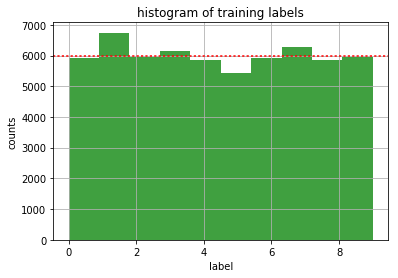

In [3]:
# Verify dataset balance

plt.hist(trainy.argmax(1), 10, facecolor='green', alpha=0.75)
plt.axhline(len(trainy) / 10, color='red', ls=':')
plt.xlabel('label')
plt.ylabel('counts')
plt.title(r'histogram of training labels')
plt.grid(True)

plt.show()

In [4]:
from sklearn.model_selection import train_test_split

trainx, validx, trainy, validy = train_test_split(
    trainx, trainy, test_size=0.3, random_state=1234)

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

logistic = Sequential(
    [Dense(10, input_dim=trainx.shape[1]),
     Activation('softmax')])
logistic.compile(
    loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

# Since logistic is convex early stopping can be from training convergence
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', min_delta=1e-4, patience=0)
logistic.fit(trainx, trainy, epochs=100, batch_size=128, callbacks=[early_stopping]);

Using TensorFlow backend.


Epoch 1/100
42000/42000 [==============================] - 0s - loss: 0.5872 - acc: 0.8580     
Epoch 2/100
42000/42000 [==============================] - 0s - loss: 0.4021 - acc: 0.8955     
Epoch 3/100
42000/42000 [==============================] - 0s - loss: 0.3673 - acc: 0.9022     
Epoch 4/100
42000/42000 [==============================] - 0s - loss: 0.3490 - acc: 0.9067     
Epoch 5/100
42000/42000 [==============================] - 0s - loss: 0.3369 - acc: 0.9094     
Epoch 6/100
42000/42000 [==============================] - 0s - loss: 0.3286 - acc: 0.9105     
Epoch 7/100
42000/42000 [==============================] - 0s - loss: 0.3219 - acc: 0.9122     
Epoch 8/100
42000/42000 [==============================] - 0s - loss: 0.3167 - acc: 0.9139     
Epoch 9/100
42000/42000 [==============================] - 0s - loss: 0.3123 - acc: 0.9149     
Epoch 10/100
42000/42000 [==============================] - 0s - loss: 0.3085 - acc: 0.9157     
Epoch 11/100
42000/42000 [=============

evaluation for logistic


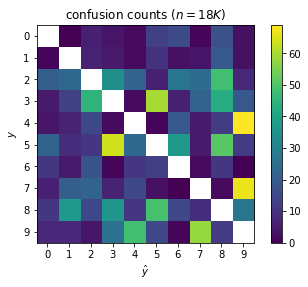

+--------------------+------------+
|   weighted roc auc |   accuracy |
+====================+============+
|           0.993163 |   0.915722 |
+--------------------+------------+


In [6]:
import sklearn.metrics

def evaluate(truey_onehot, predy_onehot):
    truey = truey_onehot.argmax(1)
    predy = predy_onehot.argmax(1)
    
    nclasses = 10

    confusion = sklearn.metrics.confusion_matrix(truey, predy).astype(float)
    np.fill_diagonal(confusion, np.nan)
    plt.imshow(confusion)
    plt.colorbar()
    plt.xticks(np.arange(nclasses))
    plt.yticks(np.arange(nclasses))
    plt.xlabel(r'$\hat{y}$')
    plt.ylabel(r'$y$')
    plt.title(r'confusion counts ($n={}K$)'.format(len(validy)//1000))
    plt.show()

    acc = sklearn.metrics.accuracy_score(truey, predy)
    rocauc = sklearn.metrics.roc_auc_score(truey_onehot, predy_onehot, average='weighted')

    print(tabulate([[rocauc, acc]], ['weighted roc auc', 'accuracy'], tablefmt='grid'))

predy = logistic.predict(validx)
print('evaluation for logistic')
evaluate(validy, predy)

In [125]:
## from keras.layers import Dropout, Reshape, Conv2D, MaxPooling2D, Maximum, LocallyConnected2D

np.random.seed(1234)
tf.set_random_seed(1234)

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization

nets = {}

nets['google'] = Sequential([
    Reshape([28, 28, 1], input_shape=(trainx.shape[1],)),
    Conv2D(32, [5, 5], strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(64, [5, 5], strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Reshape([28 * 28 * 64 // 4 // 4]),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

nets['mlp-6'] = Sequential([
    Dense(600, activation='relu', input_dim=trainx.shape[1]),
    Dense(600, activation='relu'),
    Dense(600, activation='relu'),
    Dense(600, activation='relu'),
    Dense(600, activation='relu'),
    Dense(10, activation='softmax')
])
my_input = Input(shape=(trainx.shape[1],))
net = Reshape([28, 28, 1])(my_input)
net = Conv2D(32, [5, 5], strides=(1, 1), padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=(2, 2), padding='same')(net)
parallel_lcs = [
    LocallyConnected2D(16, [5, 5], strides=(2, 2), padding='valid', activation='relu')(net)
    for _ in range(16)]
net = Maximum()(parallel_lcs)
net = Reshape([net.shape[1:].num_elements()])(net)
net = Dropout(0.8)(net)
net = Dense(10, activation='softmax')(net)
net = Model(inputs=my_input, outputs=net)
nets['my-cnn'] = net

In [126]:
! mkdir -p ../models && mkdir -p ../models/mnist

from contextlib import contextmanager
import time

@contextmanager
def rectime(name='', fmt='{: 4.0f}'):
    print(name, end='')
    sys.stdout.flush()
    t = time.time()
    yield
    t = time.time() - t
    print(fmt.format(t), 'sec')
    
save_files = {name: '../models/mnist/' + name + '-best.hdf5' for name in nets.keys()}
for net_name, net in nets.items():
    if not net_name.startswith('my-cnn'):
        continue
    print('*********************************************')
    print('Training new model:', net_name)
    print('*********************************************')

    
    with rectime(name='compiling net...'):
        net.compile(
            loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    f = save_files[net_name]
    ! if [ -f {f} ] ; then echo moving {f} to {f}-old; mv {f} {f}-old; fi
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0, patience=0)
    checkpoint = keras.callbacks.ModelCheckpoint(f, monitor='val_loss', save_best_only=True)
    # TODO more templates to have: TensorBoard on aws; filters (logistic?)
    # feeder queues
    # norms over gradients (tensorboard example?)
    with rectime():
        net.fit(
            trainx,
            trainy,
            epochs=100,
            batch_size=128,
            callbacks=[early_stopping, checkpoint],
            validation_data=(validx, validy))

*********************************************
Training new model: my-cnn
*********************************************
compiling net...   0 sec
moving ../models/mnist/my-cnn-best.hdf5 to ../models/mnist/my-cnn-best.hdf5-old
Train on 42000 samples, validate on 18000 samples
Epoch 1/100
42000/42000 [==============================] - 216s - loss: 0.5629 - acc: 0.8221 - val_loss: 0.1376 - val_acc: 0.9606
Epoch 2/100
42000/42000 [==============================] - 199s - loss: 0.2290 - acc: 0.9318 - val_loss: 0.0877 - val_acc: 0.9731
Epoch 3/100
42000/42000 [==============================] - 199s - loss: 0.1756 - acc: 0.9479 - val_loss: 0.0685 - val_acc: 0.9793
Epoch 4/100
42000/42000 [==============================] - 199s - loss: 0.1441 - acc: 0.9568 - val_loss: 0.0592 - val_acc: 0.9824
Epoch 5/100
42000/42000 [==============================] - 199s - loss: 0.1327 - acc: 0.9610 - val_loss: 0.0527 - val_acc: 0.9838
Epoch 6/100
42000/42000 [==============================] - 199s - loss: 0.11

In [84]:
nets['google'].load_weights(save_files['google'])
nets['google'].evaluate(validx, validy)

17952/18000 [============================>.] - ETA: 0s

[0.028317046098501629, 0.99127777777777781]

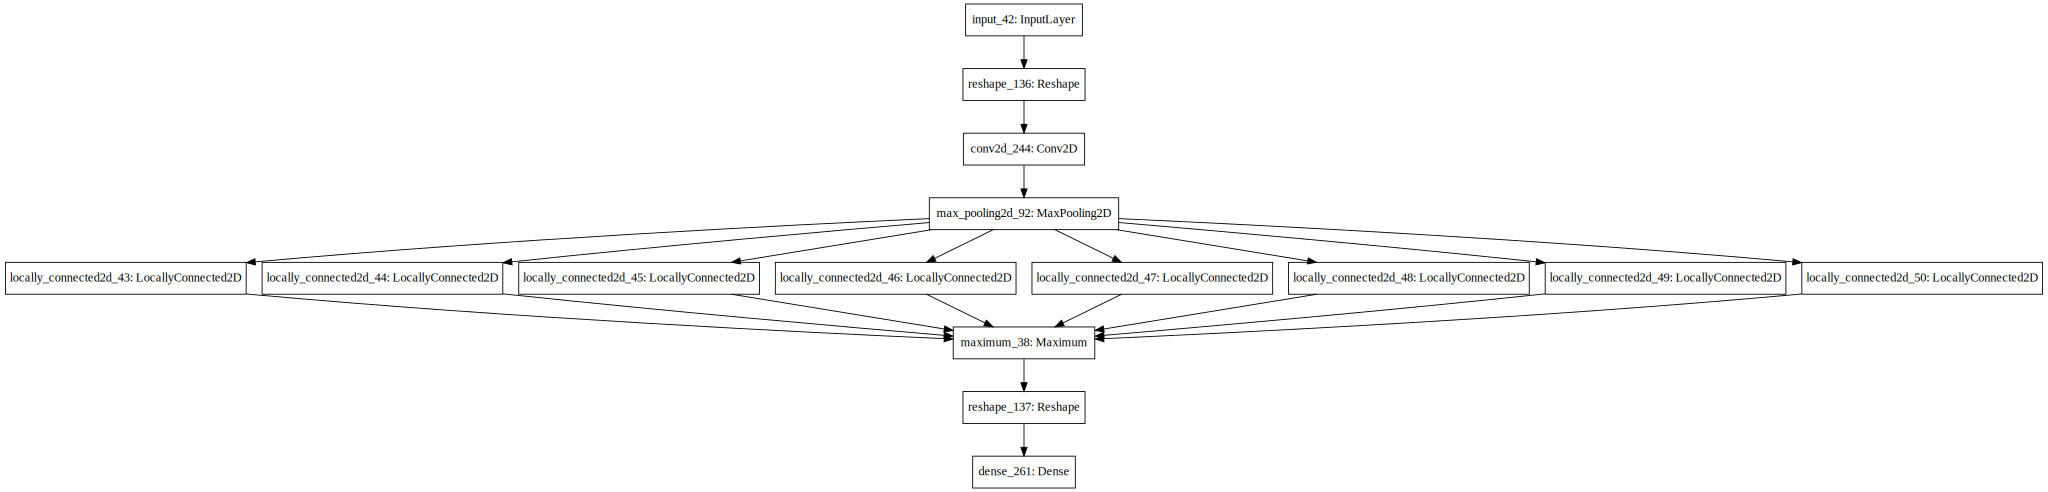

In [102]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import graphviz
nets2=nets
# https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
SVG(model_to_dot(nets['my-cnn3']).create(prog='dot', format='svg'))

In [ ]:
# todo do this via tensorboard?
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 200):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

In [15]:
from keras import backend as K
tf.image_summary('conv1/filters', kernel_transposed, max_images=3)

K.get_session().run(net.layers[4:7][0].output)

<tf.Tensor 'conv2d_2/Relu:0' shape=(?, 14, 14, 10) dtype=float32>

In [ ]:
class EarlyStopRetrain(keras.callbacks.Callback):
    """Callback that terminates training when a NaN loss is encountered."""

    def __init__(self, stop_error):
        super(EarlyStopRetrain, self).__init__()
        self.stop_error = stop_error
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            for k in self.params['metrics']:
                if k in self.totals:
                    # Make value available to next callbacks.
                    logs[k] = self.totals[k] / self.seen

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print('Batch %d: Invalid loss, terminating training' % (batch))
                self.model.stop_training = True

In [ ]:
# Iterate architectures (but still scoped)
# and a special version of LeNet I call what-I-vaguely-remember-of-LeNet-net.

# NO MORE TENSORLAYER - TF-slim.

# TODO smarter init
# TODO class balancing?
#http://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/utils.html#class_balancing_oversample
def mlp_drop3(input_layer, is_train=True):
    with tf.variable_scope('mlp-dropout-3', reuse=True):
        net = tl.layers.DropoutLayer(input_layer, 0.8, True, is_train, name='drop_input')
        net = tl.layers.DenseLayer(net, n_units=800, act=tf.nn.relu, name='dense1')
        net = tl.layers.DropoutLayer(net, 0.8, True, is_train, name='drop1')
        net = tl.layers.DenseLayer(net, n_units=800, act=tf.nn.relu, name='dense2')
        net = tl.layers.DropoutLayer(net, 0.8, True, is_train, name='drop2')
        net = tl.layers.DenseLayer(net, n_units=10, act=tf.identity, name='dense3')
        return net

def wrap_net(network_generator, is_train=True, batch_size=None):
    x = tf.placeholder(tf.float32, shape=[batch_size, 784], name='x')
    y = tf.placeholder(tf.int64, shape=[batch_size], name='y')
    net = network_generator(tl.layers.InputLayer(x, name='input_layer3'), is_train=is_train)
    cost = tl.cost.cross_entropy(net.outputs, y, name='cost')
    output = tf.argmax(tf.nn.softmax(net.outputs, name='output'), 1)
    acc = tf.reduce_mean(output == y)
    return net, cost, acc

In [ ]:
mlp_drop_graph = tf.Graph()

with mlp_drop_graph.as_default():
    net, cost, acc = wrap_net(mlp_drop3, is_train=True, batch_size=128)

    params = network.all_params
    train_op = tf.train.AdamOptimizer(
        learning_rate=0.001, beta1=0.9, beta2=0.99, epsilon=1e-8, use_locking=False).minimize(cost)
    tl.layers.initialize_global_variables(sess)

net.print_params()
net.print_layers()


In [ ]:
# Look at http://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/utils.html#fit and below
# save to ../logs. Models can go in ../checkpoints (date and epoch count to delineate, too.)
for epoch in range(10):
    for X_train_a, y_train_a in tl.iterate.minibatches(
        X_train, y_train, batch_size, shuffle=True):
            feed_dict = {x: X_train_a, y_: y_train_a}
            feed_dict.update(network.all_drop )

In [ ]:

# TODO momentum cooling
global_step = tf.Variable(
    0, trainable=False)  # don't train a global step value
initial_learning_rate, decay_fraction, decay_period = 0.01, 0.95, 10000
learning_rate = tf.train.exponential_decay(
    initial_learning_rate,
    global_step,
    decay_period,
    decay_fraction,
    staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate) \
             .minimize(sm.cross_entropy, global_step=global_step)

sess = tf.Session()

NUM_EPOCHS = 100
NUM_FOLDS = 4
UPDATE_COARSENESS = 5
BATCH_SIZE = 50

saver = tf.train.Saver()
top_models = []

# Cross validate on random restarts
for fold, validate in enumerate(train.cross_validation(NUM_FOLDS), 1):
    print('Starting fold {}'.format(fold))
    sess.run(tf.initialize_all_variables())  # random restart
    best_in_fold_validation = np.inf
    best_in_fold_epoch = None
    best_in_fold_model = None

    for epoch in range(1, 1 + NUM_EPOCHS):
        for batch in train.new_epoch(BATCH_SIZE):
            train_step.run(feed_dict={x: batch[0], y: batch[1]}, session=sess)
        if epoch == NUM_EPOCHS or UPDATE_COARSENESS and epoch % UPDATE_COARSENESS == 0:
            valid_err = validate.multiclass_error(x, sm.y, y, session=sess)
            print('  Epoch {:3} error {}'.format(epoch, valid_err))
            if valid_err > best_in_fold_validation: break
            best_in_fold_validation = valid_err
            best_in_fold_epoch = epoch
            best_in_fold_model = saver.save(
                sess, '/tmp/tf-mnist-batch-sgd-fold-{}.ckpt'.format(fold))
    top_models.append((fold, best_in_fold_epoch, best_in_fold_model))

# We select the model based on the entire training data set rather than the error from the
# cross-validation fold because that error was used for early stopping. It's unfair to
# compare across the folds the same accuracy since some folds might be easier than others.
# Doing this helps the test accuracy by about 0.5%.
best_fold, best_epoch, best_model = None, None, None
best_error = np.inf
for fold, epoch, model in top_models:
    saver.restore(sess, model)
    error = train.multiclass_error(x, sm.y, y, session=sess)
    if best_error > error:
        best_error, best_fold, best_epoch, best_model = error, fold, epoch, model

print('Fold {}/{} epoch {}/{} with inside training dataset-error {}'
      .format(best_fold, NUM_FOLDS, best_epoch, NUM_EPOCHS, best_error))

saver.restore(sess, best_model)

print('Test error', test.multiclass_error(x, sm.y, y, session=sess))
sess.close()

In [ ]:
cnn_prefix = 'mnist-cnn-'
cnn_suffix = '.ckpt'
available_epochs = [x for x in os.listdir('../data')
                    if x.startswith(cnn_prefix) and x.endswith(cnn_suffix)]
print(available_epochs)

def extract_epoch_number(s):
    return int(s[len(cnn_prefix):-len(cnn_suffix)])

available_epochs = [extract_epoch_number(s) for s in available_epochs]
max_epoch = max(available_epochs or [None])
print('{} saved epoch files; using largest epoch ({}) as start'
      .format(len(available_epochs), max_epoch))

def epoch_to_filename(e):
    return '../data/' + cnn_prefix + str(e) + cnn_suffix


In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()

x = tf.placeholder("float", shape=[None, 784]) # any batch size on flattened pixel values
y = tf.placeholder("float", shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Don't drop out when testing by setting keep_prob to 1.0
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

output = regression.SoftMax(h_fc1_drop, y)

train_step = tf.train.AdamOptimizer(1e-4).minimize(output.cross_entropy)

sess = tf.Session()

saver = tf.train.Saver()
if max_epoch:
    saver.restore(sess, epoch_to_filename(max_epoch))
    print('Restoring CNN from epoch {}'.format(max_epoch))
else:
    print('Starting CNN training from scratch')
    sess.run(tf.initialize_all_variables())
    max_epoch = 0

BATCH_SIZE = 100
NUM_EPOCHS = 35
UPDATE_COARSENESS = 5
for epoch in range(max_epoch + 1, NUM_EPOCHS + 1):
    for i, batch in enumerate(train.new_epoch(BATCH_SIZE), 1):
        tot_batches = train.size // BATCH_SIZE
        two_percent_done = i * 50 // tot_batches
        print(('\rEpoch {}/{} [' + two_percent_done * '-' + (50 - two_percent_done) * ' '
               + '] {}/{}').format(epoch, NUM_EPOCHS, i, tot_batches), end='')
        train_step.run(feed_dict={x: batch[0], y: batch[1], keep_prob: 0.5}, session=sess)

    print(']')
    name = saver.save(sess, epoch_to_filename(epoch))
    print('  Saved to', name)
    if epoch == NUM_EPOCHS or UPDATE_COARSENESS and epoch % UPDATE_COARSENESS == 0:
        err = train.multiclass_error(x, output.y, y, feed_dict={keep_prob:1.0}, session=sess)
        print('  Epoch {}/{} training error {}'.format(epoch, NUM_EPOCHS, err))

print('Test error {}'.format(test.multiclass_error(
            x, output.y, y, feed_dict={keep_prob:1.0}, session=sess)))

sess.close()